In [59]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

from sklearn.model_selection import train_test_split, learning_curve

In [17]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [18]:
df = pd.read_csv('Fraud.csv')

In [19]:
df.head(500)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
495,1,CASH_IN,160347.32,C1972143064,7965270.68,8125617.99,C33524623,724867.22,1517262.16,0,0
496,1,CASH_IN,289272.75,C312168418,8125617.99,8414890.75,C75457651,413976.60,31469.78,0,0
497,1,CASH_IN,63189.26,C95369743,8414890.75,8478080.00,C1860513229,101925.00,0.00,0,0
498,1,CASH_IN,196725.32,C26928827,8478080.00,8674805.32,C451111351,2248012.90,3940085.21,0,0


In [8]:

df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [9]:
df.isnull().values.any()

False

In [10]:
print(df.head(5))
print(df.describe())
print(df.info())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
               step        amount  oldBalanceOrig  newBalanceOrig  \
count  6.362620e+06  6.362620e

Text(0, 0.5, 'Frequency')

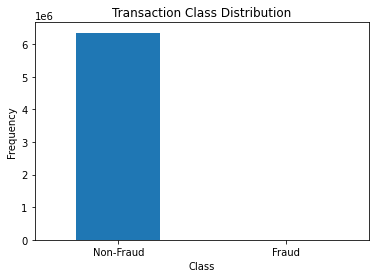

In [24]:
LABELS = ["Non-Fraud", "Fraud"]

count_classes = pd.value_counts(df['isFraud'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [26]:
## Get the Fraud and the normal dataset 

fraud = df[df['isFraud']==1]

non_fraud = df[df['isFraud']==0]

In [27]:
print(fraud.shape,non_fraud.shape)


(8213, 11) (6354407, 11)


In [29]:
fraud.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [30]:
non_fraud.amount.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

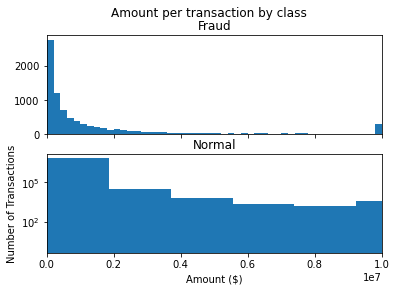

In [40]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(non_fraud.amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 10000000))
plt.yscale('log')
plt.show();

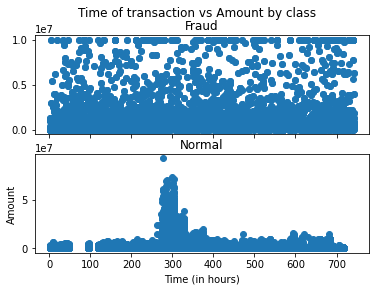

In [45]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.step, fraud.amount)
ax1.set_title('Fraud')
ax2.scatter(non_fraud.step, non_fraud.amount)
ax2.set_title('Normal')
plt.xlabel('Time (in hours)')
plt.ylabel('Amount')
plt.show()

There are 5 Transaction type as shown below:

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


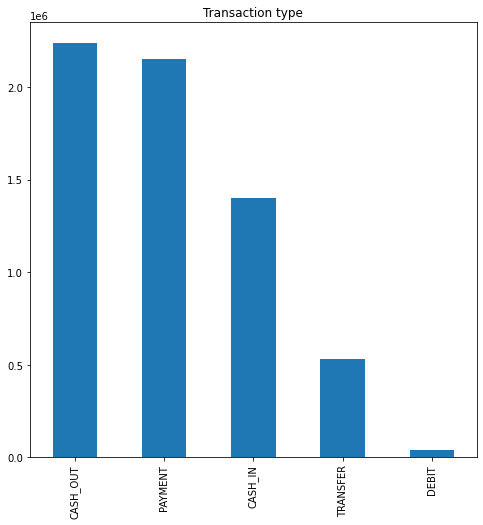

In [11]:
print(df.type.value_counts())

f, ax = plt.subplots(1, 1, figsize=(8, 8))
df.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

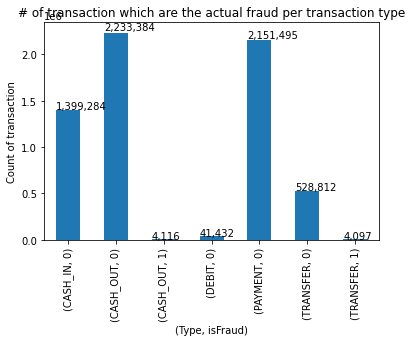

In [14]:
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

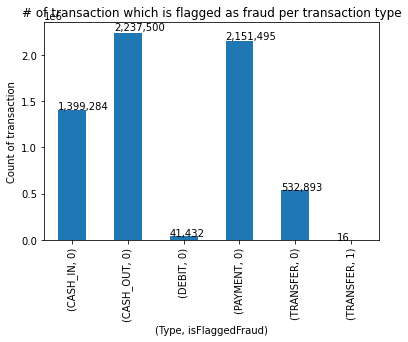

In [16]:
ax = df.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which is flagged as fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

 Only 16 transfer transactions as fraud

                  amount  oldBalanceOrig  oldBalanceDest   isFraud
amount          1.000000       -0.002762        0.294137  0.076688
oldBalanceOrig -0.002762        1.000000        0.066243  0.010154
oldBalanceDest  0.294137        0.066243        1.000000 -0.005885
isFraud         0.076688        0.010154       -0.005885  1.000000


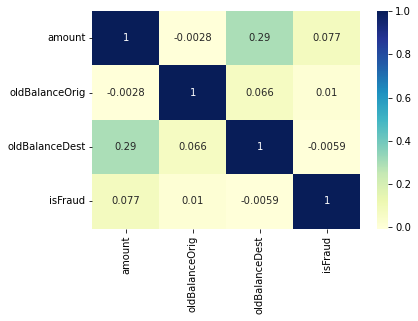

In [13]:
df_corr = df[['amount', 'oldBalanceOrig', 'oldBalanceDest', 'isFraud']]

print(df_corr.corr())

# plotting correlation heatmap
dataplot = sns.heatmap(df_corr.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()



In [48]:
## Take some sample of the data

df1= df.sample(frac = 0.1,random_state=1)

df1.shape


(636262, 11)

In [50]:
df.shape

(6362620, 11)

In [53]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[df1['isFraud']==1]

Valid = data1[df1['isFraud']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [54]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0012888646188564514
Fraud Cases : 819
Valid Cases : 635443


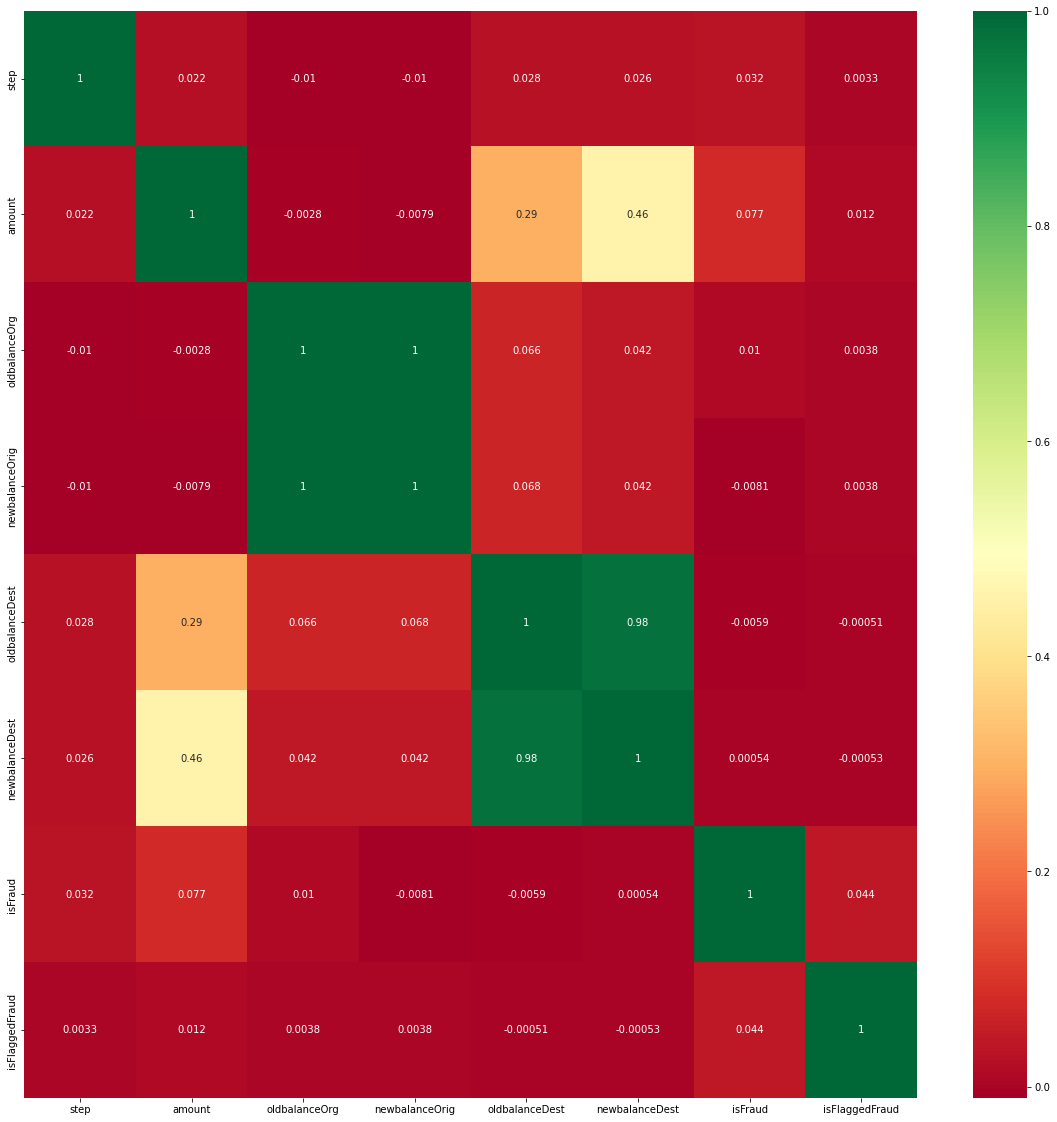

In [56]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = df1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [72]:
#Create independent and Dependent Features
columns = df1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["isFraud","type","nameOrig","nameDest"]]
# Store the variable we are predicting 
target = "isFraud"
# Define a random state 
state = np.random.RandomState(42)
X = df1[columns]
Y = df1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(636262, 7)
(636262,)


In [73]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [74]:
type(classifiers)

dict

In [ ]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 1490
Accuracy Score :
0.9976581974092433
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635443
           1       0.09      0.09      0.09       819

    accuracy                           1.00    636262
   macro avg       0.55      0.55      0.55    636262
weighted avg       1.00      1.00      1.00    636262

Local Outlier Factor: 1618
Accuracy Score :
0.9974570224215811
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635443
           1       0.01      0.01      0.01       819

    accuracy                           1.00    636262
   macro avg       0.51      0.51      0.51    636262
weighted avg       1.00      1.00      1.00    636262

